In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

# Налаштування стилю для графіків
sns.set(style="whitegrid")

print('[+] Налаштування завершено')

[+] Налаштування завершено


In [5]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Завантажує очищений датасет з вказаного шляху.

    :param file_path: Шлях до CSV файлу очищеного датасету.
    :return: DataFrame з завантаженими даними.
    """
    try:
        df = pd.read_csv(file_path)
        print("[+] Дані успішно завантажені.")
        return df
    except FileNotFoundError:
        print(f"[!] Файл за шляхом {file_path} не знайдено.")
        raise

In [7]:
DATA_FILE: str = '../../lab03/source/sample.csv'
DATAFRAME: pd.DataFrame = load_data(DATA_FILE)

[+] Дані успішно завантажені.


In [8]:
def select_clusters(df: pd.DataFrame, cluster_column: str, top_n: int = 2) -> pd.DataFrame:
    """
    Вибирає топ-N кластерів з найбільшою кількістю елементів.

    :param df: Вхідний DataFrame з кластерними мітками.
    :param cluster_column: Назва стовпця з кластерними мітками.
    :param top_n: Кількість найбільших кластерів для вибору.
    :return: DataFrame, що містить лише топ-N кластерів.
    """
    top_clusters = df[cluster_column].value_counts().nlargest(top_n).index.tolist()
    df_top = df[df[cluster_column].isin(top_clusters)].copy()
    print(f"Вибрано топ-{top_n} кластерів: {top_clusters}")
    return df_top

In [10]:
TOP_CLUSTERS = select_clusters(DATAFRAME,  'KMeans_Cluster')

Вибрано топ-2 кластерів: [0, 1]


In [12]:
def encode_clusters(df: pd.DataFrame, cluster_column: str) -> pd.DataFrame:
    """
    Кодує кластерні мітки у бінарні класи.

    :param df: Вхідний DataFrame з кластерними мітками.
    :param cluster_column: Назва стовпця з кластерними мітками.
    :return: DataFrame з доданим стовпцем 'Class'.
    """
    clusters = df[cluster_column].unique()
    if len(clusters) != 2:
        raise ValueError("[!] Кількість кластерів для бінарної класифікації має бути рівною 2.")

    df['Class'] = df[cluster_column].apply(lambda x: 1 if x == clusters[0] else 0)
    print("[+] Кластерні мітки успішно закодовані у бінарні класи.")
    return df

In [13]:
TOP_CLUSTERS = encode_clusters(TOP_CLUSTERS, 'KMeans_Cluster')

[+] Кластерні мітки успішно закодовані у бінарні класи.


In [14]:
TOP_CLUSTERS

,Port Name,State,Port Code,Border,Date,Measure,Value,Location,KMeans_Cluster,Hierarchical_Cluster,Class
1,Ambrose,North Dakota,3410,US-Canada Border,10/01/2011 12:00:00 AM,Trucks,-0.480732,POINT (-103.49 49),0,1,1
2,Nogales,Arizona,2604,US-Mexico Border,10/01/1998 12:00:00 AM,Rail Containers Empty,0.798166,POINT (-110.94 31.33),1,0,0
3,Lukeville,Arizona,2602,US-Mexico Border,09/01/2011 12:00:00 AM,Truck Containers Full,-0.480732,POINT (-112.82 31.880000000000003),1,3,0
4,Progreso,Texas,2309,US-Mexico Border,01/01/2009 12:00:00 AM,Train Passengers,-0.480732,POINT (-97.95 26.06),1,3,0
5,Lukeville,Arizona,2602,US-Mexico Border,02/01/1996 12:00:00 AM,Trucks,-0.282720,POINT (-112.82 31.880000000000003),1,3,0
...,...,...,...,...,...,...,...,...,...,...,...
5992,Ambrose,North Dakota,3410,US-Canada Border,06/01/2000 12:00:00 AM,Rail Containers Full,-0.480732,POINT (-103.49 49),0,1,1
5993,Santa Teresa,New Mexico,2408,US-Mexico Border,08/01/1999 12:00:00 AM,Truck Containers Full,1.090275,POINT (-106.68 31.78),1,0,0
5994,Ferry,Washington,3013,US-Canada Border,10/01/2002 12:00:00 AM,Rail Containers Full,-0.480732,POINT (-118.76000000000002 49),0,1,1
5996,Roma,Texas,2310,US-Mexico Border,10/01/2014 12:00:00 AM,Rail Containers Full,-0.480732,POINT (-99.02 26.4),1,3,0


In [15]:
def prepare_features(df: pd.DataFrame, feature_columns: list, target_column: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Підготовлює матрицю ознак та вектор цільових значень для моделі.

    :param df: Вхідний DataFrame.
    :param feature_columns: Список стовпців, що використовуються як ознаки.
    :param target_column: Назва стовпця з цільовими значеннями.
    :return: Кортеж (X, y), де X — матриця ознак, y — вектор цільових значень.
    """
    X = df[feature_columns].values
    y = df[target_column].values
    return X, y

In [16]:
feature_columns: list = ['Value', 'Port Code']
target_column: str = 'Class'

In [17]:
X: np.ndarray
y: np.ndarray
X, y = prepare_features(TOP_CLUSTERS, feature_columns, target_column)

In [19]:
def split_data(X: np.ndarray, y: np.ndarray, test_size: float = 0.3, random_state: int = 42) -> tuple:
    """
    Розділяє дані на навчальну та тестову вибірки.

    :param X: Матриця ознак.
    :param y: Вектор цільових значень.
    :param test_size: Частка даних для тестової вибірки.
    :param random_state: Випадковий стан для відтворюваності.
    :return: Кортеж (X_train, X_test, y_train, y_test).
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [20]:
X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray
X_train, X_test, y_train, y_test = split_data(X, y)

In [33]:
X_train

array([[-1.51802622e-01,  3.40300000e+03],
       [-4.80732186e-01,  3.42600000e+03],
       [-4.80732186e-01,  3.40700000e+03],
       ...,
       [ 4.00504482e-01,  3.31800000e+03],
       [ 3.86594525e-01,  2.30200000e+03],
       [-4.80732186e-01,  2.60300000e+03]])

In [22]:
def train_svm_classifier(X_train: np.ndarray, y_train: np.ndarray, kernel: str = 'rbf') -> SVC:
    """
    Тренує модель SVM з вказаним ядром.

    :param X_train: Навчальна матриця ознак.
    :param y_train: Навчальний вектор цільових значень.
    :param kernel: Ядро для SVM (наприклад, 'linear', 'rbf', 'poly').
    :return: Навчену модель SVM.
    """
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train, y_train)
    print(f"[+] SVM модель з ядром '{kernel}' успішно натренована.")
    return svm

In [35]:
svm_model: SVC = train_svm_classifier(X_train, y_train, kernel='rbf')

[+] SVM модель з ядром 'rbf' успішно натренована.


In [24]:
def evaluate_model(model: SVC, X_test: np.ndarray, y_test: np.ndarray) -> None:
    """
    Оцінює модель на тестових даних та виводить точність та звіт класифікації.

    :param model: Навчена модель.
    :param X_test: Тестова матриця ознак.
    :param y_test: Тестовий вектор цільових значень.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Точність класифікації: {accuracy:.2f}")
    print("Звіт класифікації:")
    print(report)

In [25]:
evaluate_model(svm_model, X_test, y_test)

Точність класифікації: 1.00
Звіт класифікації:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00      1188

    accuracy                           1.00      1519
   macro avg       1.00      1.00      1.00      1519
weighted avg       1.00      1.00      1.00      1519


In [28]:
def plot_svm(model: SVC, X: np.ndarray, y: np.ndarray, feature_names: list,
                                   title: str = 'SVM Decision Boundary with RBF Kernel') -> None:
    """
    Будує графік класифікації SVM з розділяючою гіперплощиною для ядра RBF.
    
    :param model: Навчена модель SVM.
    :param X: Матриця ознак (двовимірна).
    :param y: Вектор цільових значень.
    :param feature_names: Список назв ознак.
    :param title: Заголовок графіка.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1', alpha=0.6)

    # Створення сітки для побудови межі класифікації
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                         np.linspace(ylim[0], ylim[1], 500)
                         )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.decision_function(grid)
    Z = Z.reshape(xx.shape)

    # Побудова контурної лінії межі класифікації
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend(title='Клас')
    plt.tight_layout()
    plt.savefig('svm_decision_boundary_rbf.png')
    plt.show()
    print("Графік класифікації SVM з розділяючою гіперплощиною збережено як 'svm_decision_boundary_rbf.png'.")

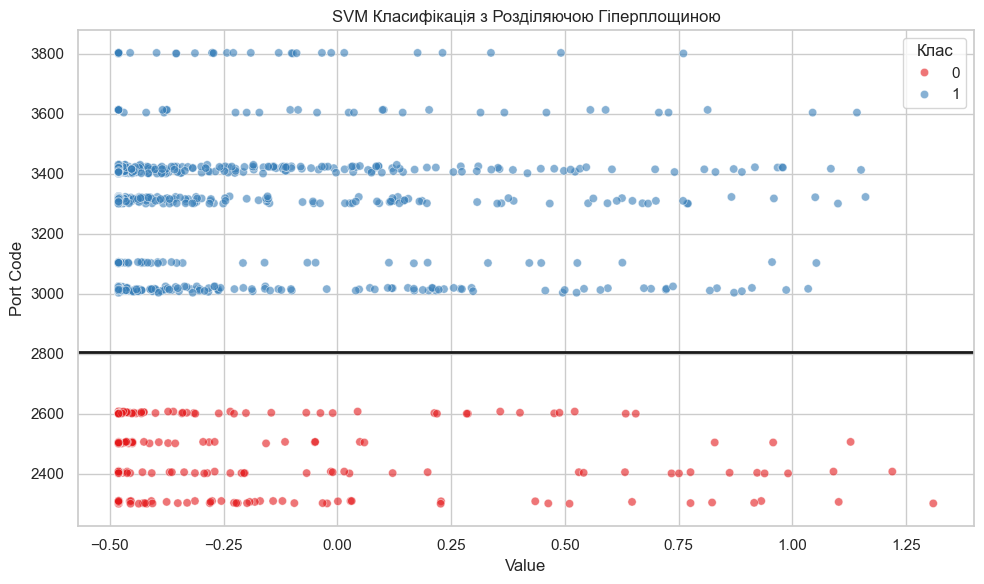

Графік класифікації SVM з розділяючою гіперплощиною збережено як 'svm_decision_boundary_rbf.png'.


In [29]:
plot_svm(
    svm_model, X_test, y_test, feature_columns, 
    title='SVM Класифікація з Розділяючою Гіперплощиною'
)